In [1]:
import torch
torch.__version__

'2.4.0+cu121'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_dir = '/content/drive/My Drive/RottenFruitData02/Original Image/'

In [4]:
!unzip going_modular.zip

Archive:  going_modular.zip
   creating: going_modular/going_modular/
   creating: going_modular/going_modular/__pycache__/
  inflating: going_modular/going_modular/__pycache__/engine.cpython-39.pyc  
  inflating: going_modular/going_modular/__pycache__/predictions.cpython-39.pyc  
  inflating: going_modular/going_modular/engine.py  
  inflating: going_modular/going_modular/model_builder.py  
  inflating: going_modular/going_modular/predictions.py  
  inflating: going_modular/going_modular/train.py  
  inflating: going_modular/going_modular/utils.py  


In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [7]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 77.8 MB/s eta 0:00:00


In [8]:
from urllib.request import urlopen
from PIL import Image
import timm

In [9]:
# from urllib.request import urlopen
# from PIL import Image
# import timm

# #pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# pretrained_vit_weights = timm.create_model('vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True)

# pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# # Freezing the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False

# class_names = ['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

# set_seeds()
# pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained model from timm
pretrained_vit = timm.create_model('vit_betwixt_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True).to(device)

# Freezing the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Define the number of classes
# class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']

# Modify the final classification head to match the number of classes
# Adjusting the last layer to match the number of classes
in_features = pretrained_vit.head.in_features  # Get the number of input features for the final layer
pretrained_vit.head = nn.Linear(in_features, len(class_names)).to(device)

# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Now your model is ready for training or evaluation

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [10]:
!pip install torchinfo

In [11]:
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

# top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

In [12]:
# pretrained_vit_transforms = pretrained_vit_weights.transforms()
# print(pretrained_vit_transforms)
from torchvision import transforms

# Get the model's configuration for preprocessing
model_config = pretrained_vit.default_cfg

# Define the appropriate transforms for your model
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize(model_config['input_size'][-2:]),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=model_config['mean'], std=model_config['std'])  # Normalize with the model's mean and std
])

print(pretrained_vit_transforms)



Compose(
    Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [13]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import random
import matplotlib.pyplot as plt

NUM_WORKERS = os.cpu_count()

class CustomAugmentation:
    def __init__(self):
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        self.additive_gaussian_noise = transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05)

    def __call__(self, image):
        # Random flip
        if random.random() > 0.5:
            image = F.hflip(image)

        # Random brightness and contrast adjustment
        image = transforms.ColorJitter(brightness=0.1, contrast=0.1)(image)

        # Random rotation
        if random.random() > 0.5:
            angle = random.choice([0, 90, 180, 270])
            image = F.rotate(image, angle)

        # Apply Gaussian blur
        if random.random() > 0.5:
            image = self.gaussian_blur(image)

        return image

class AddGaussianNoise:
    def __call__(self, image):
        return image + torch.randn_like(image) * 0.05

# Defining transform with custom augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images first
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure image is in RGB format
    CustomAugmentation(),           # Apply custom augmentations
    transforms.ToTensor(),          # Convert images to tensors
    AddGaussianNoise()              # Add Gaussian noise to tensors
])

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

def create_dataloaders(
    data_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = 2
):
    # Using ImageFolder to create dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=transform)

    # Determine the split sizes for training and testing
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size

    # Split the dataset into training and testing sets
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # class names
    class_names = full_dataset.classes

    # Turning datasets into dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [14]:
# Setup dataloaders

# Call the modified create_dataloaders function
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    data_dir=dataset_dir,  # No need for separate train_dir and test_dir
    transform=pretrained_vit_transforms,
    batch_size=32  # You can increase the batch size if you have more samples or better hardware
)

In [15]:
# !unzip going_modular.zip

In [16]:
import numpy as np
epoch=5
def lr_schedule(epoch):
    initial_lr = 1e-3
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [17]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=lr_schedule(epoch))
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=3,
                                      device=device)

Learning rate:  0.0003678794411714424


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8632 | train_acc: 0.7457 | test_loss: 0.2155 | test_acc: 0.9422
Epoch: 2 | train_loss: 0.1769 | train_acc: 0.9523 | test_loss: 0.1274 | test_acc: 0.9734
Epoch: 3 | train_loss: 0.1087 | train_acc: 0.9746 | test_loss: 0.0826 | test_acc: 0.9844


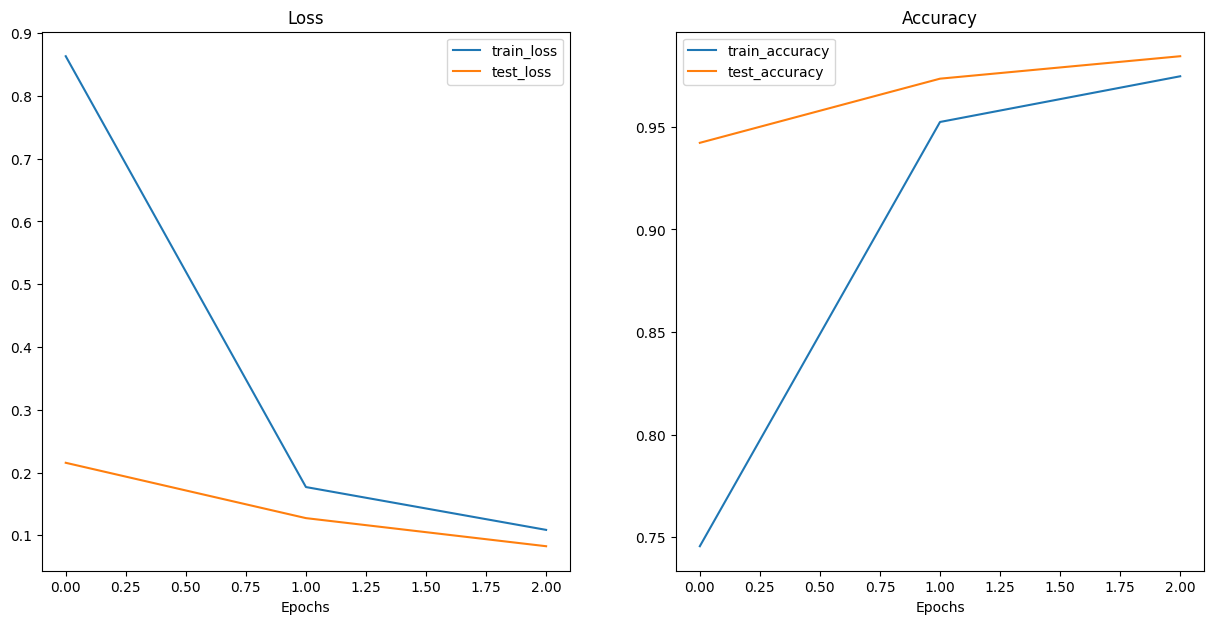

In [18]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def calculate_metrics_and_plot(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Print precision, recall, and F1 score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with class names rotated
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)  # Rotate class names on x-axis
    plt.yticks(rotation=0)   # Rotate class names on y-axis (keeps them horizontal)
    plt.title('Confusion Matrix')
    plt.show()


Precision: 0.9846
Recall: 0.9844
F1 Score: 0.9843


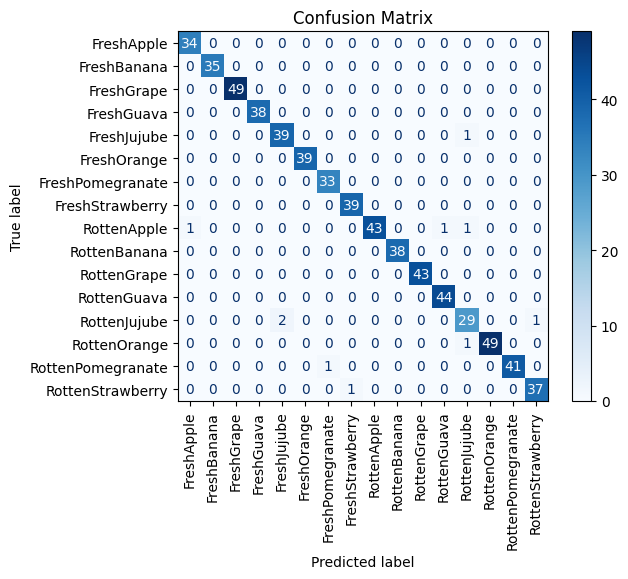

In [21]:
calculate_metrics_and_plot(
    model=pretrained_vit,
    dataloader=test_dataloader_pretrained,
    class_names=class_names,
    device=device
)

# Not included



In [ ]:
# !pip install grad-cam

In [ ]:
# !pip install timm

In [ ]:
# # import torch

# # from pytorch_grad_cam import GradCAM
# # from torch import Tensor
# # from transformers import ViTForImageClassification


# # def grad_cam(images: Tensor, vit: ViTForImageClassification, use_cuda: bool = False) -> Tensor:
# #     """Performs the Grad-CAM method on a batch of images (https://arxiv.org/pdf/1610.02391.pdf)."""

# #     # Wrap the ViT model to be compatible with GradCAM
# #     vit = model(vit)
# #     vit.eval()

# #     # Create GradCAM object
# #     cam = GradCAM(
# #         model=vit,
# #         target_layers=[vit.target_layer],
# #         reshape_transform=_reshape_transform,
# #         use_cuda=use_cuda,
# #     )

# #     # Compute GradCAM masks
# #     grayscale_cam = cam(
# #         input_tensor=images,
# #         targets=None,
# #         eigen_smooth=True,
# #         aug_smooth=True,
# #     )

# #     return torch.from_numpy(grayscale_cam)


# # def _reshape_transform(tensor, height=14, width=14):
# #     result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

# #     # Bring the channels to the first dimension
# #     result = result.transpose(2, 3).transpose(1, 2)

# #     return result


# # class ViTWrapper(torch.nn.Module):
# #     """ViT Wrapper to use with Grad-CAM."""

# #     def __init__(self, vit: ViTForImageClassification):
# #         super().__init__()
# #         self.vit = vit

# #     def forward(self, x: torch.Tensor) -> torch.Tensor:
# #         return self.vit(x).logits

# #     @property
# #     def target_layer(self):
# #         return self.vit.vit.encoder.layer[-2].layernorm_after

# import torch
# from transformers import AutoModelForImageClassification, AutoFeatureExtractor
# from torch.nn import functional as F
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np
# import requests
# from torchvision import transforms

# from urllib.request import urlopen
# from PIL import Image
# import timm
# import torch
# import torch.nn as nn

#  # Device configuration
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load a pre-trained model from timm
# pretrained_vit = timm.create_model('vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True).to(device)

# # Load the pre-trained Vision Transformer model and feature extractor
# model_name = "vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k"  # replace with your Hugging Face model name
# model = AutoModelForImageClassification.from_pretrained(model_name)
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# model.eval()

# # Function to preprocess the images
# def preprocess(image_paths):
#     images = []
#     for img_path in image_paths:
#         image = Image.open(img_path).convert("RGB")
#         inputs = feature_extractor(images=image, return_tensors="pt")
#         images.append(inputs["pixel_values"])
#     return torch.cat(images)

# # GRAD-CAM implementation
# class GradCAM:
#     def _init_(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
#         self.gradients = None
#         self.activations = None
#         target_layer.register_forward_hook(self.save_activation)
#         target_layer.register_full_backward_hook(self.save_gradient)

#     def save_activation(self, module, input, output):
#         self.activations = output

#     def save_gradient(self, module, grad_input, grad_output):
#         self.gradients = grad_output[0]

#     def _call_(self, x, class_idx=None):
#         output = self.model(x)
#         if class_idx is None:
#             class_idx = torch.argmax(output, dim=1)
#         self.model.zero_grad()
#         loss = F.cross_entropy(output, class_idx)
#         loss.backward()

#         gradients = self.gradients.detach().cpu().numpy()
#         activations = self.activations.detach().cpu().numpy()
#         weights = np.mean(gradients, axis=(2, 3))
#         grad_cam = np.zeros(activations.shape[2:], dtype=np.float32)

#         for i, w in enumerate(weights[0]):
#             grad_cam += w * activations[0, i, :, :]

#         grad_cam = np.maximum(grad_cam, 0)
#         grad_cam = cv2.resize(grad_cam, x.shape[2:])
#         grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())
#         return grad_cam

# # Load and preprocess the images
# image_paths = ["test_image_1.jpg", "test_image_2.jpg", "test_image_3.jpg",
#                "test_image_4.jpg", "test_image_5.jpg", "test_image_6.jpg"]  # replace with your image paths
# inputs = preprocess(image_paths)

# # Initialize GradCAM for the specific layer in the model
# target_layer = model.vit.encoder.layer[-1].output.dropout  # adjust based on your model architecture
# grad_cam = GradCAM(model, target_layer)

# # Generate and visualize the GRAD-CAM heatmaps
# for i in range(len(image_paths)):
#     img = inputs[i].unsqueeze(0)
#     heatmap = grad_cam(img)

#     # Plotting the image and the heatmap
#     img = transforms.ToPILImage()(img.squeeze())
#     heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap) / 255
#     overlayed_img = np.array(img) * 0.5 + heatmap * 0.5

#     plt.figure(figsize=(6, 6))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img)
#     plt.title("Original Image")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(overlayed_img)
#     plt.title("GRAD-CAM Heatmap")
#     plt.axis("off")

#     plt.show()

# Lime

In [ ]:
!pip install lime

In [ ]:
# import torch
# import numpy as np
# from lime import lime_image
# from lime.wrappers.scikit_image import SegmentationAlgorithm
# from skimage.segmentation import quickshift
# from torchvision.transforms.functional import to_pil_image
# import matplotlib.pyplot as plt

# # Your ViT model
# model = pretrained_vit

# # Prediction function
# def predict(input_tensor):
#     model.eval()
#     with torch.no_grad():
#         # Resize input_tensor to match model's expected input size
#         input_tensor = torch.from_numpy(input_tensor).permute(0, 3, 1, 2).float()
#         input_tensor = input_tensor.to('cuda')  # If using GPU
#         output = model(input_tensor)
#         probabilities = torch.nn.functional.softmax(output, dim=1)
#     return probabilities.cpu().numpy()

# # Get a batch of data from the test dataloader
# dataiter = iter(test_dataloader_pretrained)
# images, labels = next(dataiter)  # Correct usage of next()

# # Select a single image and its corresponding label
# image = images[0]  # Get the first image in the batch
# label = labels[0].item()  # Get the corresponding label

# # Convert the image back to PIL format
# pil_image = to_pil_image(image)

# # Convert the PIL image to a NumPy array and ensure it's the correct shape (H, W, C)
# image_np = np.array(pil_image)

# # Apply LIME
# explainer = lime_image.LimeImageExplainer()
# segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)

# explanation = explainer.explain_instance(
#     image_np,
#     classifier_fn=predict,
#     top_labels=5,
#     hide_color=0,
#     num_samples=1000,
#     segmentation_fn=segmentation_fn
# )

# # Visualize explanation for the selected label
# temp, mask = explanation.get_image_and_mask(
#     label,
#     positive_only=False,
#     num_features=10,
#     hide_rest=False
# )

# plt.imshow(temp)
# plt.show()


In [ ]:
import torch
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import quickshift
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Your ViT model
model = pretrained_vit

# Prediction function
def predict(input_tensor):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.from_numpy(input_tensor).permute(0, 3, 1, 2).float()
        input_tensor = input_tensor.to('cuda')  # If using GPU
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy()

# Define the class names for the rotten classes
rotten_classes = ['rottenapples', 'rottenbanana', 'rottenoranges']

# Initialize a dictionary to store one image per rotten class and its label index
rotten_images = {}

# Loop through the test dataloader to find one image per rotten class
for images, labels in test_dataloader_pretrained:
    for i in range(len(labels)):
        class_name = class_names[labels[i]]
        if class_name in rotten_classes and class_name not in rotten_images:
            rotten_images[class_name] = (images[i], labels[i].item())
        # Break the loop once we've found images for all rotten classes
        if len(rotten_images) == len(rotten_classes):
            break
    if len(rotten_images) == len(rotten_classes):
        break

# Apply LIME to each rotten class image and visualize the explanations
fig, axes = plt.subplots(1, len(rotten_classes), figsize=(15, 5))

for ax, class_name in zip(axes, rotten_classes):
    image, label = rotten_images[class_name]

    # Convert the image to PIL format and then to NumPy array
    pil_image = to_pil_image(image)
    image_np = np.array(pil_image)

    # Apply LIME
    explainer = lime_image.LimeImageExplainer()
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)

    explanation = explainer.explain_instance(
        image_np,
        classifier_fn=predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=segmentation_fn
    )

    # Visualize explanation for the specific rotten class
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )

    ax.imshow(temp)
    ax.set_title(class_name)
    ax.axis('off')

plt.show()
